# Predict House Prices in King County, Washington  

## Overview 

King County, Washington is the most populous county in Washington. It is also the 12th most populous in the United States. Washington's most populous city is Seattle.

Our goal is to predict the price of a house based on houses sold between May 2014 to May 2015 in King County, Washington State, USA.  

In [1]:
import opendatasets as od
from sklearn import linear_model

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# 1. Data Wrangling

## 1.1 Collect

In [2]:
#get the data from API
#https://www.kaggle.com/swathiachath/kc-housesales-data > data with explanations 
housingAPI = od.download("https://www.kaggle.com/shivachandel/kc-house-data")

Skipping, found downloaded files in "./kc-house-data" (use force=True to force download)


In [3]:
#get the data and read it 
housingData = pd.read_csv('./kc-house-data/kc_house_data.csv')

## 1.2 Clean and Organize Data

In [4]:
#check for duplicates
housingData.duplicated()

duplicate = housingData[housingData.duplicated()]
print(duplicate)

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

[0 rows x 21 columns]


In [5]:
#check for any null values
housingData.isnull().values.any()

#check how many null values
housingData.isnull().sum()

# 2 null values are in the sqft_above column > index 10 & 17
housingData[housingData['sqft_above'].isna()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10,1736800520,20150403T000000,662500.0,3,2.5,3560,9796,1.0,0,0,...,8,NaN,1700,1965,0,98007,47.6007,-122.145,2210,8925
17,6865200140,20140529T000000,485000.0,4,1.0,1600,4300,1.5,0,0,...,7,NaN,0,1916,0,98103,47.6648,-122.343,1610,4300


In [6]:
#Remove the rows where sqft_above is not NA
newHousingDF = housingData[housingData['sqft_above'].notna()]

newHousingDF.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# 2. Preprocessing and Training

## 2.1 Train and Split

I am going to use a 70/30 train/test split

In [7]:
len(newHousingDF) * .7, len(newHousingDF) * .3

(15127.699999999999, 6483.3)

In [8]:
#drop price column
X_train, X_test, y_train, y_test = train_test_split(newHousingDF.drop(columns='price'), 
                                                    newHousingDF.price, test_size=0.3, 
                                                    random_state=47)

In [9]:
#view X train and test shape
X_train.shape, X_test.shape

((15127, 20), (6484, 20))

In [10]:
#view y train and test shape
y_train.shape, y_test.shape

((15127,), (6484,))

In [11]:
#remove columns that are objects data types
object_list = ['date']

object_train = X_train[object_list]
object_test = X_test[object_list]

X_train.drop(columns=object_list, inplace=True)
X_test.drop(columns=object_list, inplace=True)

X_train.shape, X_test.shape

((15127, 19), (6484, 19))

In [12]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

id                 int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above       float64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [13]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

id                 int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above       float64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

There's only numeric data types in our X now.

## 2.2 Initial Not-Even-A-Model 

Let's start by determining if the mean is a good predictor. 

In [14]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

541317.1673828254

In [15]:
#Fit the dummy regressor on the training data
#call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[541317.16738283]])

The dummy regressor and the train mean are very similar

## 2.2.1 Metrics
#### 2.2.1.1 R-squared, or coefficient of determination
This is a measure of the proportion of variance in the dependent variable that is predicted by our "model".

In [16]:
#Calculate the R^2 
def r_sqrd(y, ypred):
    
    #Arguments:
    #y -- the observed values
    #ypred -- the predicted values
    
    ybar = np.mean(y)
    total_sum_square = np.sum((y-ybar)**2) # total sum of squares error
    res_sum_square = np.sum((y-ypred)**2) #residual sum of squares error
    R2 = 1.0 - res_sum_square / total_sum_square
    
    return R2

In [17]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([541317.16738283, 541317.16738283, 541317.16738283, 541317.16738283,
       541317.16738283])

Use dummy regressor for y_tr_pred

In [18]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([541317.16738283, 541317.16738283, 541317.16738283, 541317.16738283,
       541317.16738283])

In [19]:
#call the r squared function
r_sqrd(y_train, y_tr_pred) 

0.0

Make your predictions by creating an array of length the size of the test set with the single value of the (training) mean.

In [20]:
y_te_pred = train_mean * np.ones(len(y_test))
r_sqrd(y_test, y_te_pred) 

-0.0001319455771289224

In [21]:
# R-squared function
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0001319455771289224)

#### 2.2.1.2 Mean Absolute Error

This is very simply the average of the absolute errors:

In [22]:
"""Arguments:
    y -- the observed values
    ypred -- the predicted values"""

def mae(y, ypred):
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [23]:
mae(y_train, y_tr_pred)

235817.34913915992

In [24]:
mae(y_test, y_te_pred)

230706.5690754976

Mean Absolute Error Function

In [25]:
#Mean Absolute Error
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(235817.3491391798, 230706.5690755041)

Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around $230,707 if you guessed house price based on an average of known values.

#### 2.2.1.3 Mean Squared Error

Another common metric (and an important one internally for optimizing machine learning models) is the mean squared error. This is simply the average of the square of the errors:

In [26]:
"""
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """

#Calculate the MSE 
def mse(y, ypred):
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [27]:
mse(y_train, y_tr_pred)

137770535842.7563

In [28]:
mse(y_test, y_te_pred)

127834154202.32181

In [29]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([371174.53555269, 357539.02472642])

Mean Squared Error Function:

In [30]:
#mean_squared_error built in function
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(137770535842.75708, 127834154202.32216)

## 2.3 Initial Models

### 2.3.1 Imputing missing feature (predictor) values

##### 2.3.1.1 Learn the values to impute from the train set

In [31]:
X_defaults_median = X_train.median()
X_defaults_median

id               3.904921e+09
bedrooms         3.000000e+00
bathrooms        2.250000e+00
sqft_living      1.910000e+03
sqft_lot         7.606000e+03
floors           1.500000e+00
waterfront       0.000000e+00
view             0.000000e+00
condition        3.000000e+00
grade            7.000000e+00
sqft_above       1.560000e+03
sqft_basement    0.000000e+00
yr_built         1.975000e+03
yr_renovated     0.000000e+00
zipcode          9.806500e+04
lat              4.757260e+01
long            -1.222310e+02
sqft_living15    1.840000e+03
sqft_lot15       7.630000e+03
dtype: float64

##### 2.3.1.2 Apply the imputation to both train and test splits

In [32]:
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

##### 2.3.1.3 Scale the data

In [33]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

##### 2.3.1.4 Train the model on the train split

In [34]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

##### 2.3.1.5 Make predictions using the model on both train and test splits

In [35]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

#### 2.3.1.6 Assess model performance

In [36]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.696792409536885, 0.7067752006204633)

In [37]:
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(126857.32663989742, 126578.84820141118)

In [38]:
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(41773072209.69459, 37479199005.28559)

#### 2.3.1.2 Impute missing values with the mean

###### 2.3.1.2.1 Learn the values to impute from the train set

In [39]:
#As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

id               4.572135e+09
bedrooms         3.370794e+00
bathrooms        2.114117e+00
sqft_living      2.081964e+03
sqft_lot         1.521123e+04
floors           1.492794e+00
waterfront       6.742910e-03
view             2.319693e-01
condition        3.408673e+00
grade            7.656839e+00
sqft_above       1.790184e+03
sqft_basement    2.917804e+02
yr_built         1.970892e+03
yr_renovated     8.391763e+01
zipcode          9.807805e+04
lat              4.756078e+01
long            -1.222144e+02
sqft_living15    1.986246e+03
sqft_lot15       1.295119e+04
dtype: float64

##### 2.3.1.2.2 Apply the imputation to both train and test splits

In [40]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

##### 2.3.1.2.3 Scale the data

In [41]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

##### 2.3.1.2.4 Train the model on the train split

In [42]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

##### 2.3.1.2.5 Make predictions using the model on both train and test splits

In [43]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

##### 2.3.1.2.6 Assess model performance

In [44]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.696792409536885, 0.7067752006204633)

In [45]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(126857.32663989742, 126578.84820141118)

In [46]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(41773072209.69459, 37479199005.28559)

### 2.3.2 Pipelines

#### 2.3.2.1 Define the pipeline

In [47]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [48]:
type(pipe)

sklearn.pipeline.Pipeline

In [49]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

#### 2.3.2.2 Fit the pipeline

In [50]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

#### 2.3.2.3 Make predictions on the train and test sets

In [51]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

#### 2.3.2.4 Assess performance

In [52]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.696792409536885, 0.7067752006204633)

Compare from previous results

In [53]:
median_r2

(0.696792409536885, 0.7067752006204633)

In [54]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(126857.32663989742, 126578.84820141118)

In [55]:
median_mae

(126857.32663989742, 126578.84820141118)

In [56]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(41773072209.69459, 37479199005.28559)

In [57]:
median_mse

(41773072209.69459, 37479199005.28559)

## 2.4 Refining The Linear Model

### 2.4.1 Define the pipeline

Redefine your pipeline to include this feature selection step:

In [58]:
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
#Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

### 2.4.2 Fit the pipeline

In [59]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f9a778abdc0>)),
                ('linearregression', LinearRegression())])

### 2.4.3 Assess performance on the train and test set

In [60]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [61]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6400751898127358, 0.6426109349211075)

In [62]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(137898.70979399714, 136220.72670668465)

### 2.4.4 Define a new pipeline to select a different number of features

In [63]:
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

### 2.4.5 Fit the pipeline

In [64]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x7f9a778abdc0>)),
                ('linearregression', LinearRegression())])

### 2.4.6 Assess performance on train and test data

In [65]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [66]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6877160133953701, 0.7013982203999498)

In [67]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(128159.93406944933, 126988.2255413755)

### 2.4.7 Assessing performance using cross-validation

In [68]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [69]:
cv_scores = cv_results['test_score']
cv_scores

array([0.67322313, 0.69404464, 0.68489204, 0.69200287, 0.68661464])

In [70]:
np.mean(cv_scores), np.std(cv_scores)

(0.6861554656925666, 0.007286749195085894)

In [71]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.67, 0.7 ])

### 2.4.8 Hyperparameter search using GridSearchCV

In [72]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [73]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [74]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [75]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f9a778abdc0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19]})

In [76]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [77]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 19}

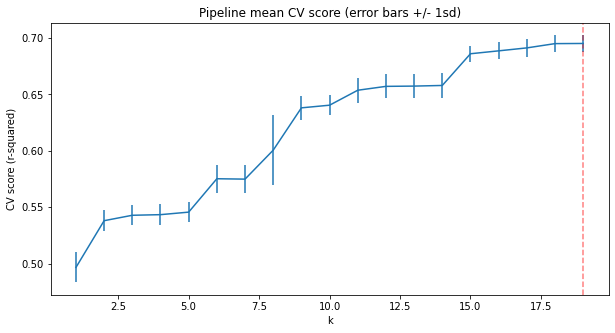

In [78]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [79]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [80]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

grade            112508.979399
sqft_living       85864.334290
lat               84534.872266
sqft_above        81796.200349
waterfront        47449.041108
view              41356.305654
bathrooms         31951.265048
sqft_basement     24818.603397
condition         17793.428975
sqft_living15     11796.101346
yr_renovated       7024.710676
sqft_lot           6583.742716
floors             2087.618402
id                -2779.410928
sqft_lot15       -11832.950787
zipcode          -33259.255654
long             -33559.737132
bedrooms         -34278.245449
yr_built         -75973.587247
dtype: float64

The biggest positive feature is grade. 'grade' and 'price' have a positive correlation as shown in the EDA. 

## 2.5 Random Forest Model

### 2.5.1 Define the pipeline

In [81]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

### 2.5.2 Fit and assess performance using cross-validation

In [82]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate( RF_pipe, X_train, y_train, cv=5)

In [83]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.88407934, 0.88714809, 0.88336305, 0.88520436, 0.87813116])

In [84]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.883585199231599, 0.0030118426660173717)

### 2.5.3 Hyperparameter search using GridSearchCV

In [85]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [86]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [88]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [89]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 483,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [90]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.88641065, 0.88735705, 0.88615971, 0.88622508, 0.88005328])

In [91]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8852411544867655, 0.0026294708885447595)

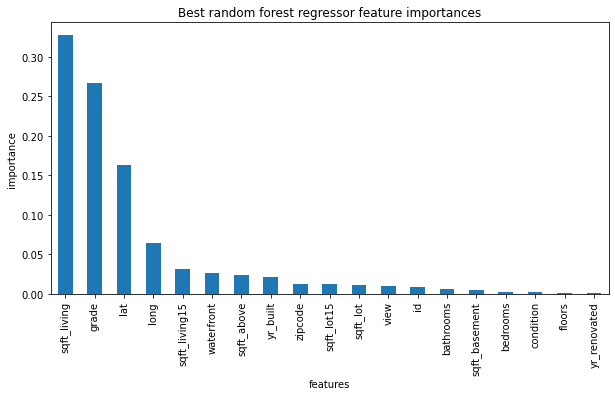

In [92]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The top four groups are "sqft_living", 'grade', 'lat', 'long'

## 2.6 Final Model Selection

### 2.6.1 Linear regression model performance

In [93]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [94]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(127077.49258864342, 2309.4694754865054)

In [95]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

126578.84820141118

### 2.6.2 Random forest regression model performance

In [96]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [97]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(69929.6092561046, 930.6045036447869)

In [98]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

68411.80935416724

### 2.6.3 Conclusion




## 2.7 Data quantity assessment

In [99]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

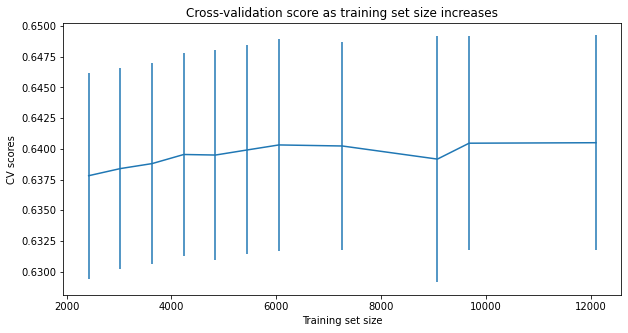

In [100]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');